### Imports

In [21]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import models, transforms
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import random
from pathlib import Path

### Paths

In [22]:
SRC_DIR = Path.cwd()
ROOT_DIR = SRC_DIR.parent
DATA_DIR = os.path.join(ROOT_DIR, 'dataset')
PREPROCESSED_DIR = os.path.join(DATA_DIR, 'preprocessed')
MODEL_DIR = os.path.join(ROOT_DIR, 'models')
CBM_DIR = os.path.join(MODEL_DIR, 'cbm')
os.makedirs(CBM_DIR, exist_ok=True)


In [23]:
CSV_PATH = os.path.join(DATA_DIR, 'csv_mappings', 'train.csv')
CSV_CONCEPTS_PATH = os.path.join(DATA_DIR, 'csv_mappings', 'train_concepts.csv')

# Data Preperation

In [24]:
CLASS_NAMES = {
    0: "amanita",
    1: "boletus",
    2: "chantelle",
    3: "deterrimus",
    4: "rufus",
    5: "torminosus",
    6: "aurantiacum",
    7: "procera",
    8: "involutus",
    9: "russula"
}

CONCEPT_LABELS = ["cap_color", "cap_shape", "cap_texture", "ring_present"]

CONCEPT_VALUES = {
    "cap_color": ["red", "brown", "yellow", "white"],
    "cap_shape": ["convex", "flat", "bulbous", "inverted"],
    "cap_texture": ["scaly", "smooth", "warty"],
    "ring_present": ["yes", "no"]
}

CONCEPT_MAPPING = {
    0: {"cap_color": "red", "cap_shape": "flat", "cap_texture": "warty", "ring_present": "yes"},            # Amanita 
    1: {"cap_color": "brown", "cap_shape": "convex", "cap_texture": "smooth", "ring_present": "no"},        # Boletus 
    2: {"cap_color": "yellow", "cap_shape": "inverted", "cap_texture": "smooth", "ring_present": "no"},     # Chantelle
    3: {"cap_color": "red", "cap_shape": "flat", "cap_texture": "smooth", "ring_present": "no"},            # Deterrimus 
    4: {"cap_color": "brown", "cap_shape": "inverted", "cap_texture": "smooth", "ring_present": "no"},      # Rufus 
    5: {"cap_color": "white", "cap_shape": "inverted", "cap_texture": "scaly", "ring_present": "no"},       # Torminosus 
    6: {"cap_color": "brown", "cap_shape": "convex", "cap_texture": "smooth", "ring_present": "no"},        # Aurantiacum
    7: {"cap_color": "white", "cap_shape": "bulbous", "cap_texture": "scaly", "ring_present": "yes"},       # Procera
    8: {"cap_color": "brown", "cap_shape": "convex", "cap_texture": "smooth", "ring_present": "no"},        # Involutus 
    9: {"cap_color": "red", "cap_shape": "flat", "cap_texture": "smooth", "ring_present": "no"},            # Russula 
}

In [25]:
df = pd.read_csv(CSV_PATH)

In [26]:
def get_concept_labels(mushroom_class):
    concepts = CONCEPT_MAPPING.get(mushroom_class, {})
    return concepts

concepts_list = []
for index, row in df.iterrows():
    mushroom_class = row['Mushroom']
    concepts = get_concept_labels(mushroom_class)
    concepts_list.append(concepts)

concept_df = pd.DataFrame(concepts_list)
df_with_concepts = pd.concat([df, concept_df], axis=1)

In [27]:
df_with_concepts.to_csv(CSV_CONCEPTS_PATH, index=False)
print(f"New CSV with concepts saved to: {CSV_CONCEPTS_PATH}")

New CSV with concepts saved to: c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\dataset\csv_mappings\train_concepts.csv


# Training

### Classes & Functions

In [28]:
class ConceptBottleneckModel(nn.Module):
    def __init__(self, num_concepts, num_classes):
        super(ConceptBottleneckModel, self).__init__()

        self.feature_extractor = models.resnet50(pretrained=True)

        for param in self.feature_extractor.parameters():
            param.requires_grad = False
        
        self.feature_extractor.fc = nn.Linear(self.feature_extractor.fc.in_features, num_concepts)

        for param in self.feature_extractor.fc.parameters():
            param.requires_grad = True

        self.classifier = nn.Sequential(
            nn.Linear(num_concepts, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

        for param in self.classifier.parameters():
            param.requires_grad = True

    def forward(self, x):
        concepts = self.feature_extractor(x)
        predictions = self.classifier(concepts)
        return concepts, predictions


In [29]:
class ConceptMushroomDataset(Dataset):
    def __init__(self, preprocessed_dir, csv_path, transform=None):
        self.preprocessed_dir = preprocessed_dir
        self.csv_data = pd.read_csv(csv_path)
        self.transform = transform

        self.image_ids = self.csv_data['Image'].values
        self.labels = self.csv_data['Mushroom'].values

        concept_columns = ["cap_color", "cap_shape", "cap_texture", "ring_present"]
        self.concepts = pd.get_dummies(self.csv_data[concept_columns]).values.astype('float32')

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = str(self.image_ids[idx]).zfill(5)
        label = self.labels[idx]
        concepts = torch.tensor(self.concepts[idx], dtype=torch.float32)

        image_path = os.path.join(self.preprocessed_dir, f"{image_id}.pt")
        image = torch.load(image_path, weights_only=True)

        if self.transform:
            image = self.transform(image)

        return image, label, concepts


In [30]:
def get_data_loaders(preprocessed_dir, csv_path, batch_size=32):
    dataset = ConceptMushroomDataset(preprocessed_dir, csv_path)

    indices = list(range(len(dataset)))
    train_indices, temp_indices = train_test_split(indices, test_size=0.3, random_state=42)
    val_indices, test_indices = train_test_split(temp_indices, test_size=0.5, random_state=42)

    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)
    test_subset = Subset(dataset, test_indices)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


In [31]:
def calculate_concept_accuracy(predicted_concepts, ground_truth):
    predicted_classes = torch.argmax(predicted_concepts, dim=1)
    true_classes = torch.argmax(ground_truth, dim=1)
    correct = (predicted_classes == true_classes).sum().item()
    return correct

In [42]:
def train_separately_concept(model, train_loader, val_loader, device, optimizer_concept, epochs=10, patience=3):
    criterion_concept = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_total_loss = 0.0
        train_concept_correct = 0
        train_total = 0

        for images, labels, concepts in tqdm(train_loader, 
                                            desc=f"\n[Concept Training: Epoch {epoch+1}/{epochs}]",
                                            bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed}, it/s: {rate_fmt}]",
                                            ncols=100,
                                            dynamic_ncols=True,
                                            position=0,
                                            leave=True,
                                            mininterval=1):
            images, concepts = images.to(device), concepts.to(device)

            optimizer_concept.zero_grad()
            predicted_concepts, _ = model(images)

            # Compute concept loss
            loss_concept = criterion_concept(predicted_concepts, torch.argmax(concepts, dim=1))
            loss_concept.backward()
            optimizer_concept.step()

            train_total_loss += loss_concept.item()
            train_concept_correct += (predicted_concepts.argmax(dim=1) == torch.argmax(concepts, dim=1)).sum().item()
            train_total += concepts.size(0)

        train_concept_accuracy = 100 * train_concept_correct / train_total

        print(f"Train Concept Epoch {epoch+1}/{epochs}:")
        print(f"Training Concept Loss: {train_total_loss / len(train_loader):.4f}, Training Concept Accuracy: {train_concept_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_total_loss = 0.0
        val_concept_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels, concepts in val_loader:
                images, concepts = images.to(device), concepts.to(device)

                predicted_concepts, _ = model(images)

                loss_concept = criterion_concept(predicted_concepts, torch.argmax(concepts, dim=1))
                val_total_loss += loss_concept.item()
                val_concept_correct += (predicted_concepts.argmax(dim=1) == torch.argmax(concepts, dim=1)).sum().item()
                val_total += concepts.size(0)

        val_concept_accuracy = 100 * val_concept_correct / val_total

        print(f"Validation Concept Loss: {val_total_loss / len(val_loader):.4f}, Validation Concept Accuracy: {val_concept_accuracy:.2f}%")

        # Early stopping check
        if val_total_loss < best_val_loss:
            best_val_loss = val_total_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_concept_model.pth")
            print("Best model saved.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break


In [43]:
def train_separately_classification(model, train_loader, val_loader, device, optimizer_classification, epochs=10, patience=3):
    criterion_classification = nn.CrossEntropyLoss()
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_total_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels, concepts in tqdm(train_loader, 
                                            desc=f"\n[Classification Training: Epoch {epoch+1}/{epochs}]",
                                            bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed}, it/s: {rate_fmt}]",
                                            ncols=100,
                                            dynamic_ncols=True,
                                            position=0,
                                            leave=True,
                                            mininterval=1):     
        
            optimizer_classification.zero_grad()
            _, predictions = model(images)
            
            loss_classification = criterion_classification(predictions, labels)
            loss_classification.backward()
            optimizer_classification.step()
            
            train_total_loss += loss_classification.item()
            train_correct += (predictions.argmax(dim=1) == labels).sum().item()
            train_total += labels.size(0)
        
        train_accuracy = 100 * train_correct / train_total
        print(f"Train Classification Epoch {epoch+1}/{epochs}:")
        print(f"Training Classification Loss: {train_total_loss / len(train_loader):.4f} \t Training Classification Accuracy: {train_accuracy:.2f}%")

        # Validation phase
        model.eval()
        val_total_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels, concepts in val_loader:
                images, labels = images.to(device), labels.to(device)
                _, predictions = model(images)
                loss_classification = criterion_classification(predictions, labels)
                val_total_loss += loss_classification.item()
                val_correct += (predictions.argmax(dim=1) == labels).sum().item()
                val_total += labels.size(0)

        val_loss = val_total_loss / len(val_loader)
        val_accuracy = 100 * val_correct / val_total
        print(f"Validation Classification Loss: {val_loss:.4f} \t Validation Classification Accuracy: {val_accuracy:.2f}%")

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            print("Validation loss improved, saving model...")
            torch.save(model.state_dict(), 'best_classification_model.pth')
        else:
            patience_counter += 1
            print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


In [44]:
def evaluate_model(model, test_loader, device):
    criterion_concept = nn.CrossEntropyLoss()
    criterion_classification = nn.CrossEntropyLoss()

    total_samples = 0
    correct_classifications = 0
    correct_concepts = 0
    total_concept_loss = 0.0
    total_classification_loss = 0.0

    model.eval()
    with torch.no_grad():
        for images, labels, concepts in test_loader:
            images, labels, concepts = images.to(device), labels.to(device), concepts.to(device)

            predicted_concepts, predictions = model(images)

            loss_concept = criterion_concept(predicted_concepts, torch.argmax(concepts, dim=1))
            loss_classification = criterion_classification(predictions, labels)

            total_concept_loss += loss_concept.item()
            total_classification_loss += loss_classification.item()

            total_samples += labels.size(0)
            correct_classifications += (predictions.argmax(dim=1) == labels).sum().item()
            correct_concepts += (predicted_concepts.argmax(dim=1) == torch.argmax(concepts, dim=1)).sum().item()

    concept_accuracy = 100 * correct_concepts / total_samples
    classification_accuracy = 100 * correct_classifications / total_samples
    avg_concept_loss = total_concept_loss / len(test_loader)
    avg_classification_loss = total_classification_loss / len(test_loader)

    print("\nEvaluation Results:")
    print("-------------------")
    print(f"Concept Loss:          {avg_concept_loss:.4f} \t Concept Accuracy:         {concept_accuracy:.2f}%")
    print(f"Classification Loss:   {avg_classification_loss:.4f} \t Classification Accuracy:  {classification_accuracy:.2f}%")
    print("---------------------------------------------------------")

    return concept_accuracy, classification_accuracy


### Config

In [45]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [46]:
train_loader, val_loader, test_loader = get_data_loaders(PREPROCESSED_DIR, CSV_CONCEPTS_PATH)

In [47]:
num_concepts = len(pd.get_dummies(pd.read_csv(CSV_CONCEPTS_PATH)[["cap_color", "cap_shape", "cap_texture", "ring_present"]]).columns)
num_classes = len(pd.read_csv(CSV_CONCEPTS_PATH)['Mushroom'].unique())

In [48]:
model = ConceptBottleneckModel(num_concepts, num_classes).to(device)

c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Seperate training

In [51]:
optimizer_concept = torch.optim.Adam(model.parameters(), lr=0.0005)
optimizer_classification = torch.optim.Adam(model.parameters(), lr=0.0005)

In [52]:
train_separately_concept(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=device, 
    optimizer_concept=optimizer_concept, 
    epochs=15, 
    patience=3
)

[Concept Training: Epoch 1/1]: 100%|██████████| 52/52 [elapsed: 02:16, it/s:  2.63s/it]


Train Concept Epoch 1/1:
Training Concept Loss: 1.0098, Training Concept Accuracy: 59.27%
Validation Concept Loss: 0.7526, Validation Concept Accuracy: 75.21%
Best model saved.


In [53]:
train_separately_classification(
    model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=device, 
    optimizer_classification=optimizer_classification, 
    epochs=15, 
    patience=3
)

[Classification Training: Epoch 1/3]: 100%|██████████| 52/52 [elapsed: 02:03, it/s:  2.37s/it]


Train Classification Epoch 1/3:
Training Classification Loss: 2.1742 	 Training Classification Accuracy: 25.56%
Validation Classification Loss: 1.8972 	 Validation Classification Accuracy: 42.82%
Validation loss improved, saving model...


[Classification Training: Epoch 2/3]: 100%|██████████| 52/52 [elapsed: 02:03, it/s:  2.37s/it]


Train Classification Epoch 2/3:
Training Classification Loss: 1.5811 	 Training Classification Accuracy: 51.60%
Validation Classification Loss: 1.3099 	 Validation Classification Accuracy: 56.62%
Validation loss improved, saving model...


[Classification Training: Epoch 3/3]: 100%|██████████| 52/52 [elapsed: 01:55, it/s:  2.23s/it]


Train Classification Epoch 3/3:
Training Classification Loss: 1.1303 	 Training Classification Accuracy: 63.93%
Validation Classification Loss: 1.0365 	 Validation Classification Accuracy: 63.10%
Validation loss improved, saving model...


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

concept_acc, classification_acc = evaluate_model(model, test_loader, device)

print(f"Concept Accuracy: {concept_acc:.2f}%")
print(f"Classification Accuracy: {classification_acc:.2f}%")


Evaluation Results:
-------------------
Concept Loss:          2.8695 	 Concept Accuracy:         29.30%
Classification Loss:   0.9778 	 Classification Accuracy:  70.14%
---------------------------------------------------------
Concept Accuracy: 29.30%
Classification Accuracy: 70.14%


### Intervention

##### Intervention Functions

In [55]:
def unnormalize(tensor, mean, std):
    return tensor.mul_(torch.tensor(std).view(-1, 1, 1)).add_(torch.tensor(mean).view(-1, 1, 1))


def get_random_image_data(test_loader, device):
    image, label, concepts = test_loader.dataset[random.randint(0, len(test_loader.dataset) - 1)]
    return (
        image.unsqueeze(0).to(device), 
        torch.tensor([label], device=device), 
        concepts.unsqueeze(0).to(device) if isinstance(concepts, torch.Tensor) else torch.tensor(concepts, device=device).unsqueeze(0)
    )


def display_concepts(concepts):
    idx, concept_values = 0, []
    for concept in CONCEPT_LABELS:
        selected_idx = concepts[0, idx:idx + len(CONCEPT_VALUES[concept])].argmax().item()
        concept_values.append(f"{concept}: {CONCEPT_VALUES[concept][selected_idx]}")
        idx += len(CONCEPT_VALUES[concept])
    return concept_values


def display_class_and_concepts(label, concepts, is_predicted=False):
    print('----------------------------------')
    print(f"{'Predicted' if is_predicted else 'True'} class: {CLASS_NAMES[label.item()]}")
    for concept in display_concepts(concepts):
        print(f'- {concept}')


def predict_with_model(model, image, device):
    model.eval()
    with torch.no_grad():
        concepts, logits = model(image.to(device))
        probabilities = torch.nn.functional.softmax(logits, dim=1)
        confidence, predicted_class_idx = probabilities.max(1)
    return concepts, predicted_class_idx, confidence.item()


def show_true_and_predicted(test_loader, model, device):
    tensor, true_label, true_concepts = get_random_image_data(test_loader, device)
    image = unnormalize(tensor.squeeze(), [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]).cpu().numpy().transpose((1, 2, 0))
    
    predicted_concepts, predicted_class_idx, confidence = predict_with_model(model, tensor, device)

    plt.imshow(image)
    plt.axis('off')
    plt.show()
    
    print("True class and concepts:")
    display_class_and_concepts(true_label, true_concepts)
    
    print("\n\nPredicted class and concepts:")
    display_class_and_concepts(predicted_class_idx, predicted_concepts, True)
    print(f"\nConfidence: {confidence:.2%}")

    return predicted_concepts, predicted_class_idx, true_label, image, confidence


def intervene_on_concept(concepts, concept_name, new_value):
    start_idx = sum(len(CONCEPT_VALUES[label]) for label in CONCEPT_LABELS[:CONCEPT_LABELS.index(concept_name)])
    concepts[0, start_idx:start_idx + len(CONCEPT_VALUES[concept_name])] = 0
    concepts[0, start_idx + CONCEPT_VALUES[concept_name].index(new_value)] = 1
    return concepts


def intervene_on_multiple_concepts(concepts, interventions):
    for concept_name, new_value in interventions.items():
        concepts = intervene_on_concept(concepts.clone(), concept_name, new_value)
    return concepts


def intervene_and_predict(model, modified_concepts, image, device):
    logits = model.classifier(modified_concepts)
    probabilities = torch.nn.functional.softmax(logits, dim=1)
    confidence, final_class_idx = probabilities.max(1)
    return CLASS_NAMES[final_class_idx.item()], modified_concepts, confidence.item()


def apply_intervention(predicted_concepts, corrections, model, image, device):
    modified_concepts = intervene_on_multiple_concepts(predicted_concepts, corrections)
    final_class, final_concepts, confidence_after = intervene_and_predict(model, modified_concepts, image, device)
    final_class_idx = torch.tensor([k for k, v in CLASS_NAMES.items() if v == final_class][0])

    print("\n\nAfter Intervention:")
    display_class_and_concepts(final_class_idx, final_concepts, True)
    print(f"\nConfidence: {confidence_after:.2%}")

    return final_concepts, final_class_idx, confidence_after


##### Intervention

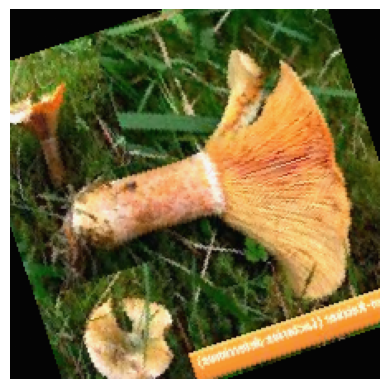

True class and concepts:
----------------------------------
True class: deterrimus
- cap_color: brown
- cap_shape: bulbous
- cap_texture: smooth
- ring_present: yes


Predicted class and concepts:
----------------------------------
Predicted class: deterrimus
- cap_color: white
- cap_shape: bulbous
- cap_texture: smooth
- ring_present: yes

Confidence: 62.87%


In [56]:
predicted_concepts, predicted_class_idx, true_label, image, confidence_before = show_true_and_predicted(test_loader, model, device)

In [60]:
corrections = {'cap_color': 'brown', 'cap_shape': 'bulbous', 'cap_texture': 'smooth', 'ring_present': 'yes'}

In [61]:
final_concepts, final_class_idx, confidence_after = apply_intervention(predicted_concepts, corrections, model, image, device)



After Intervention:
----------------------------------
Predicted class: chantelle
- cap_color: brown
- cap_shape: bulbous
- cap_texture: smooth
- ring_present: yes

Confidence: 13.35%
